In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/cs7643
import sys
sys.path.append('/content/drive/MyDrive/cs7643')
!pip install mlflow skorch
# !pip install Ipython --upgrade
%cd /content/drive/MyDrive/cs7643

Mounted at /content/drive
'Copy of run3.ipynb'	 __pycache__			   run6.ipynb
 data			 run10_selfatt_final_mnist.ipynb   run7.ipynb
 experiment_configs.py	 run1.ipynb			   run8_selfatt_unweighted.ipynb
 mlruns			 run2.ipynb			   run9_selfatt_final.ipynb
 models			 run3.ipynb			   satt-final-mnist.ipynb
 pipeline_template.py	 run4.ipynb			   tejas-run4.ipynb
 plots			 run5.ipynb
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 111.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.1/575.1 kB 43.

In [3]:
%ls

'Copy of run3.ipynb'     __pycache__/                      run6.ipynb
 data/                   run10_selfatt_final_mnist.ipynb   run7.ipynb
 experiment_configs.py   run1.ipynb                        run8_selfatt_unweighted.ipynb
 mlruns/                 run2.ipynb                        run9_selfatt_final.ipynb
 models/                 run3.ipynb                        satt-final-mnist.ipynb
 pipeline_template.py    run4.ipynb                        tejas-run4.ipynb
 plots/                  run5.ipynb


In [4]:
import pipeline_template, mlflow, torch, torchvision
from experiment_configs import configs, ExperimentConfig, ModelConfig, DataConfig
from models.resnet_self_att import ResnetSelfAtt
from models.resnet_multi_head_att import ResnetMultiHeadAtt
from models.originalBasicBlock import OriginalBasicBlock
from skorch.callbacks import LRScheduler
from skorch.dataset import ValidSplit
from torch.optim.lr_scheduler import MultiStepLR
from torchvision.transforms import transforms
mlflow.set_tracking_uri('file:/content/drive/MyDrive/cs7643/mlruns')

In [5]:
myconfig={"multi_head_att_final": lambda: ExperimentConfig(
        "MultiHeadAtt ResNet20 Final",
        DataConfig(name='CIFAR-10',
                   test_size=10000,
                   train_transform=transforms.Compose([
                transforms.RandomHorizontalFlip(0.5),
                transforms.RandomCrop(32, padding=4),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.4918687901200927, 0.49185976472299225, 0.4918583862227116], std=[0.24697121702736, 0.24696766978537033, 0.2469719877121087])
            ]),
            test_transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.4918687901200927, 0.49185976472299225, 0.4918583862227116], std=[0.24697121702736, 0.24696766978537033, 0.2469719877121087])
            ])),
        ModelConfig(model=ResnetMultiHeadAtt(OriginalBasicBlock, [3,3,3], 10),
                    lr=0.0005,
                    optimizer=torch.optim.Adam,
                    weight_decay=0.001,
                    use_reg=True,
                    batch_size=128,
                    max_epochs=64000//(45000 // 128),
                    momentum=0.9,
                    train_split=None,
                    scheduler=LRScheduler(
                        policy=MultiStepLR,
                        milestones=[
                            32000 // (45000 // 128), # == 91
                            115,
                            # 48000 // (45000 // 128) # == 136 #original
                        ],
                        gamma=0.1 # this is the multiplication factor ("divide it by 10")
                    ),
                    log_model=True,
                    early_stopping_params={
                        'patience': 20,
                        'threshold': 0.001,
                        'threshold_mode': 'rel'
                    },
                    use_early_stopping=True,
                    add_test_set_eval=True,
                    )
    )}

=== Model Details ===
ResnetMultiHeadAtt(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): OriginalBasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
    )
    (1): OriginalBasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stri

NoneType: None



Experiment ID: 694441112530602406

Run ID: f5b8adbb257742839d9eaaf23b1274fd
Model is saved at: ('/content/drive/MyDrive/cs7643', '694441112530602406/f5b8adbb257742839d9eaaf23b1274fd')
MLflow Tracking URI: file:/content/drive/MyDrive/cs7643/mlruns
Using device: CUDA
Files already downloaded and verified
Files already downloaded and verified
  epoch    test_err    train_err    train_loss      lr      dur
-------  ----------  -----------  ------------  ------  -------
      1     52.2400      53.2580        1.7298  0.0005  64.3632
      2     42.2000      44.0940        1.2725  0.0005  62.2807
      3     36.8100      37.2080        1.0699  0.0005  62.2019
      4     36.2100      35.9720        0.9425  0.0005  62.2197
      5     30.3000      29.9880        0.8497  0.0005  62.1733
      6     26.9300      26.0380        0.7756  0.0005  62.3777
      7     26.9600      25.2340        0.7153  0.0005  62.3157
      8     24.8300      23.4400        0.6715  0.0005  62.1390
      9     24.75

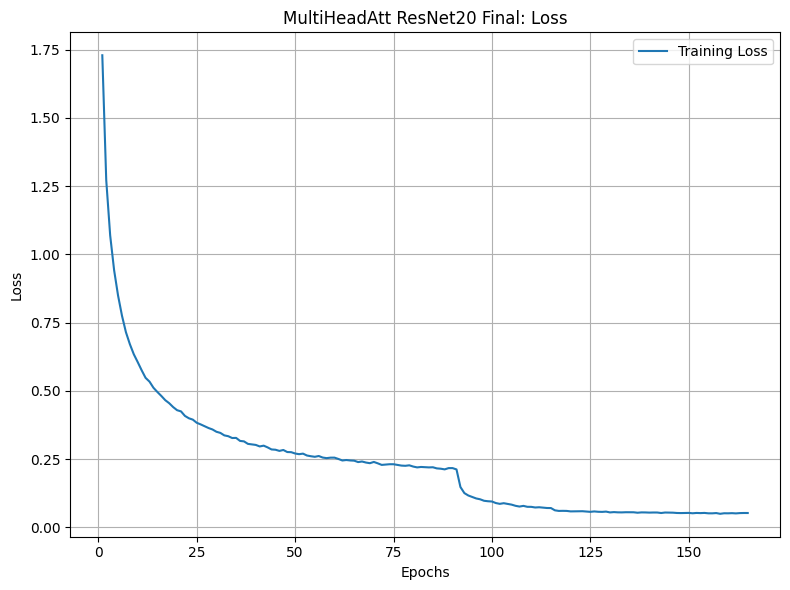

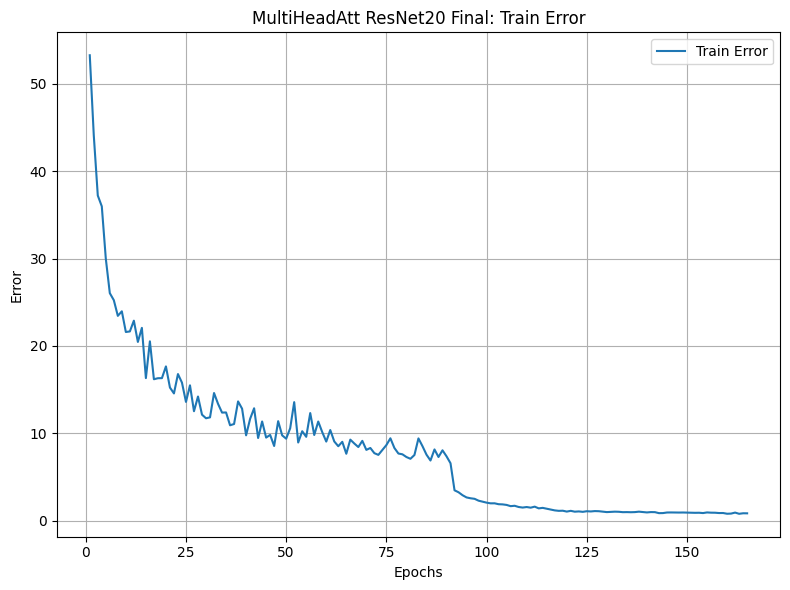

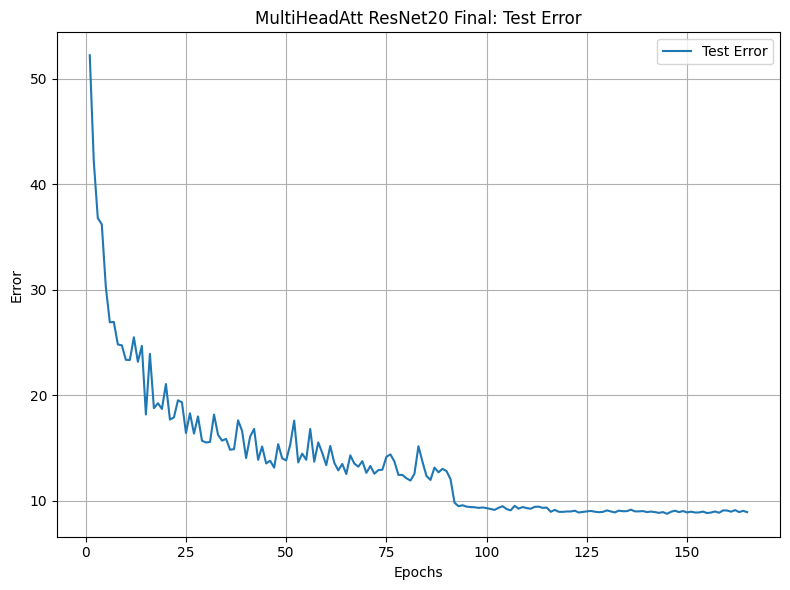

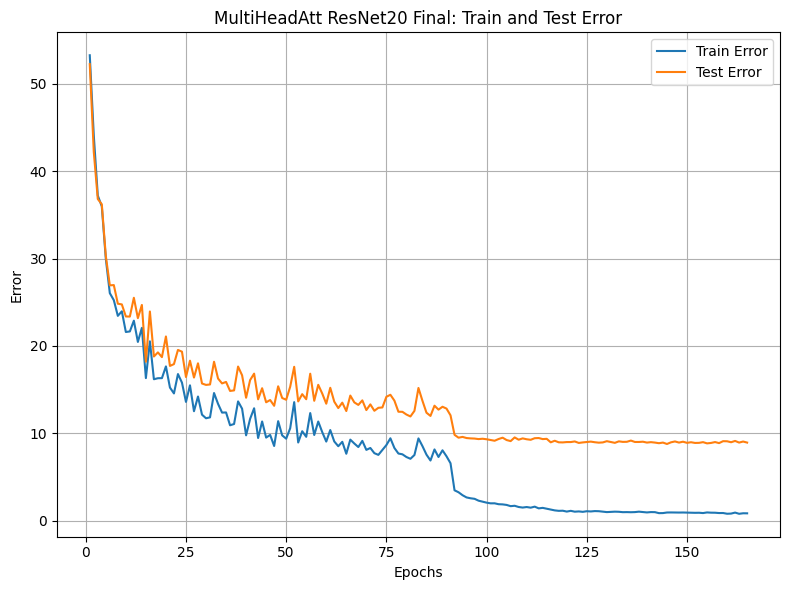

2024/12/09 06:22:31 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/09 06:22:40 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/09 06:22:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [6]:
pipeline_template.main('multi_head_att_final', True, myconfig)
# pipeline_template.main('debug_config')